In [5]:
import tensorflow as tf
import numpy as np
from music21 import *
import os
import json
import numpy as np
import pickle
from random import shuffle
import zipfile
import gensim
import random
from datetime import datetime
import shutil
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [6]:
def build_discriminator(music,num_neurons, num_dense_neurons):
    #Note: LSTM not gpu optimized
    bidir = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_neurons), input_shape=(3072, 50))
    hidden_dense = tf.keras.layers.Dense(num_dense_neurons, activation = tf.nn.relu)
    condense = tf.keras.layers.Dense(1)
    sigmoid = tf.keras.layers.Activation('sigmoid')
    
    layer1 = bidir(music)
    layer2 = hidden_dense(layer1)
    layer3 = condense(layer2)
    final_output = sigmoid(layer3)
    return tf.keras.Model(music, final_output)

In [7]:
def build_generator(original_input_music, input_music, num_neurons):
        hidden_output = tf.keras.layers.LSTM(200, activation = tf.math.sigmoid, input_shape=(1536,50))(input_music)
        repeated_output = tf.keras.layers.RepeatVector(1536)(hidden_output)
        end_sequence = tf.keras.layers.LSTM(50, return_sequences = True, activation = tf.math.sigmoid)(repeated_output)
        results = tf.keras.layers.Concatenate(1)([input_music, end_sequence])
        return tf.keras.Model(original_input_music, results), results
    

In [8]:
def next_batch(lis, length):
    counter = 0
    string = ""
    for item in lis:
        string = str(item)
        zipfilePath = ("./clean_data/" + string + ".zip")
        zip = zipfile.ZipFile(zipfilePath)
        zip.extractall("./clean_data")
        pickle_file = open("./clean_data/clean_data/" + string + ".pickle","rb")
        lis = pickle.load(pickle_file)
        pickle_file.close()
        ray = np.array(lis)
        
        ray = np.transpose(ray)
        index = random.randint(0,ray.shape[0]-1-length)
        ray = ray[index:index+length, :]
        if counter == 0:
            #print("made final")
            final = np.reshape(ray, [1,length,88])
        else:
            #print("catted")
            final = np.concatenate((final, np.reshape(ray, [1,length,88])), 0)
            #print(final.shape)
        #os.remove("./clean_data/" + string + ".pickle")
        shutil.rmtree("./clean_data/clean_data")
        counter = counter + 1
    return (final)

In [9]:
plt.ion()
plt.figure(figsize = (15,10))
fig = plt.gcf()
fig.show()
fig.canvas.draw()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


<Figure size 1080x720 with 0 Axes>

In [10]:
music = tf.keras.Input([3072,88])
input_music = tf.keras.Input([1536,88])

coded_input_music = tf.keras.Input([3072,50])

test_discrim_input = tf.keras.Input([3072,50])

encode = tf.keras.layers.Dense(50, activation = "relu")
decode = tf.keras.layers.Dense(88, activation = 'sigmoid')

encoded_dis_music = tf.keras.layers.TimeDistributed(encode)(music)
encoded_gen_music_input = tf.keras.layers.TimeDistributed(encode)(input_music)

decoded_music = tf.keras.layers.TimeDistributed(decode)(encoded_dis_music)
decoded_input_music = tf.keras.layers.TimeDistributed(decode)(coded_input_music)

decoder_model = tf.keras.Model(coded_input_music, decoded_input_music)

test_decoded_model = tf.keras.Model(music, encoded_dis_music)

decoded_input_music = tf.keras.layers.TimeDistributed(decode)(encoded_gen_music_input)

encoder_decoder = tf.keras.Model(inputs = [music, input_music], outputs = [decoded_music, decoded_input_music])

adam = tf.keras.optimizers.Adam(learning_rate = .01)
encoder_decoder.compile(optimizer = 'adam' , loss='categorical_crossentropy', loss_weights = [.5,.5])

encode.trainable = False
decode.trainable = False

W0816 17:10:02.834800 4321366912 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:

discriminator = build_discriminator(test_discrim_input, 128, 50)

real_discriminator_output = discriminator(encoded_dis_music)

real_discriminator = tf.keras.Model(music, real_discriminator_output)

discriminator.compile(optimizer = 'adam', loss='binary_crossentropy')
real_discriminator.compile(optimizer = 'adam', loss='binary_crossentropy')

W0816 17:10:03.263634 4321366912 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0816 17:10:03.265487 4321366912 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0816 17:10:03.267122 4321366912 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/py

In [12]:
generator, to_dis = build_generator(input_music, encoded_gen_music_input,128)
discriminator.trainable = False
real_discriminator.trainable = False
fake_lables = discriminator(to_dis)
combined = tf.keras.Model(input_music, fake_lables)
combined.compile(optimizer = 'adam', loss='binary_crossentropy')

In [13]:
num_total_data = 15509
batch_size = 100
epochs = 1

getting data


W0816 17:42:50.036674 4321366912 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


(100, 1536, 88)
got data
step 1


W0816 17:42:56.332407 4321366912 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0816 17:43:12.065039 4321366912 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


[[0.5277422 ]
 [0.51640254]
 [0.5146938 ]
 [0.49977317]
 [0.5175952 ]
 [0.52029383]
 [0.52390146]
 [0.5125809 ]
 [0.5256075 ]
 [0.5169955 ]
 [0.51050854]
 [0.52358025]
 [0.5110343 ]
 [0.5195651 ]
 [0.49679363]
 [0.5217737 ]
 [0.5265747 ]
 [0.52673376]
 [0.511509  ]
 [0.52386934]
 [0.51278716]
 [0.52412647]
 [0.50381714]
 [0.5034965 ]
 [0.5237511 ]
 [0.5214193 ]
 [0.51784474]
 [0.5233408 ]
 [0.50509834]
 [0.49630296]
 [0.51067775]
 [0.5319283 ]
 [0.5101699 ]
 [0.5198268 ]
 [0.51526177]
 [0.5035372 ]
 [0.53304917]
 [0.52190137]
 [0.52413946]
 [0.52995986]
 [0.5215488 ]
 [0.50410956]
 [0.50266457]
 [0.5367814 ]
 [0.49920696]
 [0.50723916]
 [0.5192705 ]
 [0.523625  ]
 [0.52541757]
 [0.5132346 ]
 [0.515428  ]
 [0.50618   ]
 [0.50324225]
 [0.5181858 ]
 [0.51539445]
 [0.5313374 ]
 [0.51642346]
 [0.52357185]
 [0.5106962 ]
 [0.5064213 ]
 [0.5257294 ]
 [0.5146546 ]
 [0.50313294]
 [0.52988744]
 [0.5213919 ]
 [0.505869  ]
 [0.5093282 ]
 [0.51212496]
 [0.5244383 ]
 [0.51539534]
 [0.52076036]
 [0.49

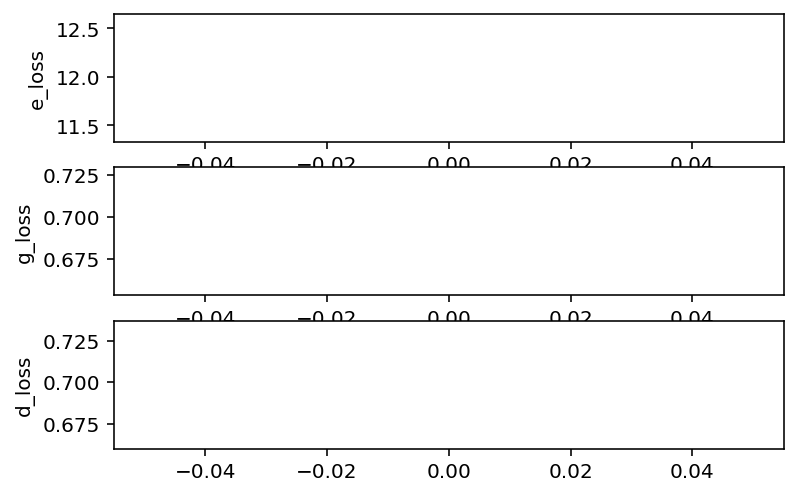

10 batches completed
getting data
(100, 1536, 88)
got data
step 1
[[0.53344977]
 [0.5195345 ]
 [0.5203891 ]
 [0.5062704 ]
 [0.5156405 ]
 [0.50946194]
 [0.5437309 ]
 [0.51757973]
 [0.5242133 ]
 [0.50935465]
 [0.5173583 ]
 [0.5282266 ]
 [0.5238811 ]
 [0.527279  ]
 [0.53469145]
 [0.507921  ]
 [0.51265585]
 [0.51374876]
 [0.51303977]
 [0.5136353 ]
 [0.510953  ]
 [0.52334416]
 [0.53605425]
 [0.5308857 ]
 [0.5303443 ]
 [0.5123049 ]
 [0.5327788 ]
 [0.5152374 ]
 [0.51653045]
 [0.5106653 ]
 [0.51644176]
 [0.52661854]
 [0.51666784]
 [0.5226997 ]
 [0.5096082 ]
 [0.5198291 ]
 [0.51092285]
 [0.51256526]
 [0.52220905]
 [0.51124597]
 [0.52714944]
 [0.5203041 ]
 [0.5502878 ]
 [0.51915675]
 [0.52308196]
 [0.51465994]
 [0.5131436 ]
 [0.5239706 ]
 [0.53531015]
 [0.52285695]
 [0.5385261 ]
 [0.5148421 ]
 [0.5126494 ]
 [0.5159444 ]
 [0.5082626 ]
 [0.5027807 ]
 [0.51452833]
 [0.5259274 ]
 [0.525318  ]
 [0.52118856]
 [0.5149915 ]
 [0.5324931 ]
 [0.5110186 ]
 [0.5081326 ]
 [0.5461661 ]
 [0.5195686 ]
 [0.518976

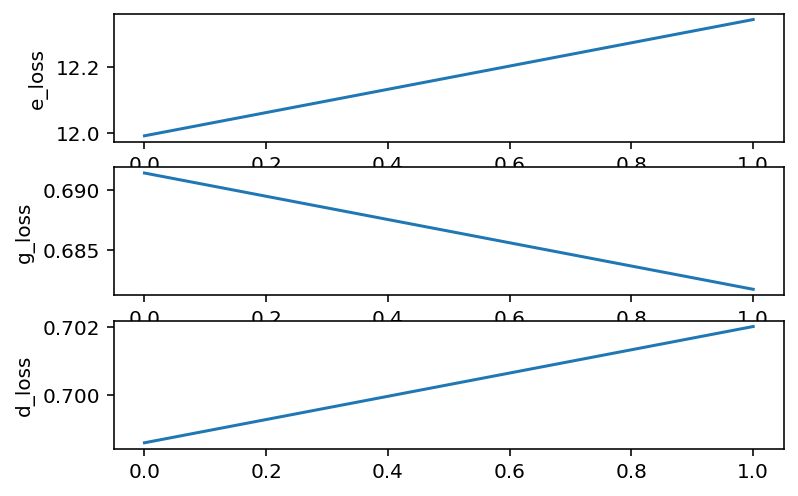

getting data
(100, 1536, 88)
got data
step 1
[[0.5059366 ]
 [0.52624273]
 [0.5294368 ]
 [0.51328593]
 [0.5316853 ]
 [0.5097022 ]
 [0.52413774]
 [0.51761335]
 [0.54043794]
 [0.52216846]
 [0.51018953]
 [0.5185232 ]
 [0.52891433]
 [0.5274167 ]
 [0.5280257 ]
 [0.526666  ]
 [0.5225763 ]
 [0.5239278 ]
 [0.5286224 ]
 [0.508546  ]
 [0.5280713 ]
 [0.5116284 ]
 [0.5171868 ]
 [0.53511703]
 [0.5275804 ]
 [0.5141159 ]
 [0.5150146 ]
 [0.53205645]
 [0.51618934]
 [0.5191442 ]
 [0.5131774 ]
 [0.53414756]
 [0.50576997]
 [0.51282173]
 [0.54368365]
 [0.54106367]
 [0.52675486]
 [0.52436   ]
 [0.51315325]
 [0.5298155 ]
 [0.51404023]
 [0.52255386]
 [0.53799504]
 [0.5106695 ]
 [0.52571255]
 [0.5257563 ]
 [0.53024125]
 [0.5298614 ]
 [0.5213138 ]
 [0.53852093]
 [0.532637  ]
 [0.5455176 ]
 [0.5348368 ]
 [0.53974605]
 [0.53466964]
 [0.51772106]
 [0.5091308 ]
 [0.518801  ]
 [0.5249396 ]
 [0.5112453 ]
 [0.51614445]
 [0.5184303 ]
 [0.5348077 ]
 [0.51431215]
 [0.51176065]
 [0.52377015]
 [0.5244788 ]
 [0.54798704]
 [0

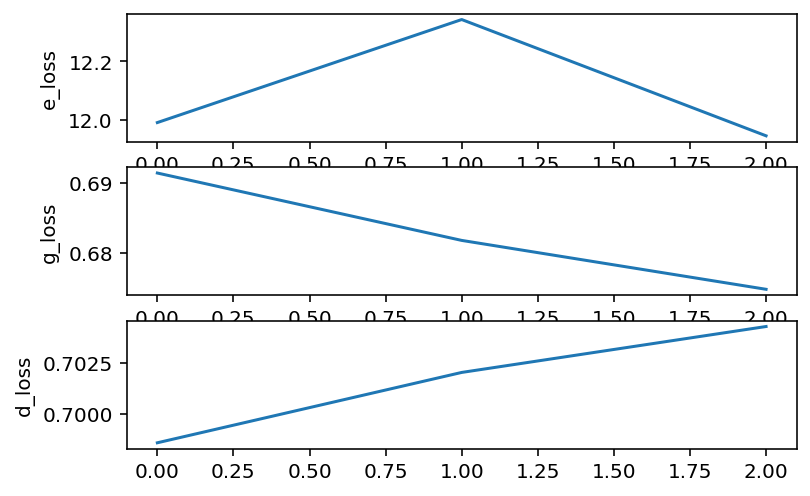

getting data
(100, 1536, 88)
got data
step 1
[[0.5140071 ]
 [0.50651455]
 [0.506113  ]
 [0.5250889 ]
 [0.5267095 ]
 [0.52688813]
 [0.5185604 ]
 [0.5192276 ]
 [0.515297  ]
 [0.51865095]
 [0.5189489 ]
 [0.5135641 ]
 [0.52808106]
 [0.5286302 ]
 [0.5166523 ]
 [0.52173847]
 [0.506447  ]
 [0.5288183 ]
 [0.5190521 ]
 [0.51782674]
 [0.5394013 ]
 [0.5285435 ]
 [0.51246583]
 [0.51605874]
 [0.5154938 ]
 [0.51209337]
 [0.5201192 ]
 [0.519029  ]
 [0.50653106]
 [0.53672594]
 [0.51608574]
 [0.51753855]
 [0.5229097 ]
 [0.5202528 ]
 [0.53728235]
 [0.5203842 ]
 [0.52499557]
 [0.5686346 ]
 [0.55223453]
 [0.53649276]
 [0.51683354]
 [0.51144034]
 [0.52299786]
 [0.51307297]
 [0.5238556 ]
 [0.5193415 ]
 [0.51964736]
 [0.5314684 ]
 [0.5154126 ]
 [0.50649977]
 [0.5331229 ]
 [0.53015155]
 [0.51367056]
 [0.52021503]
 [0.517974  ]
 [0.517989  ]
 [0.5178763 ]
 [0.5193024 ]
 [0.5294647 ]
 [0.53512824]
 [0.5091202 ]
 [0.543091  ]
 [0.51990485]
 [0.5212295 ]
 [0.5382998 ]
 [0.55636966]
 [0.5289218 ]
 [0.5108551 ]
 [0

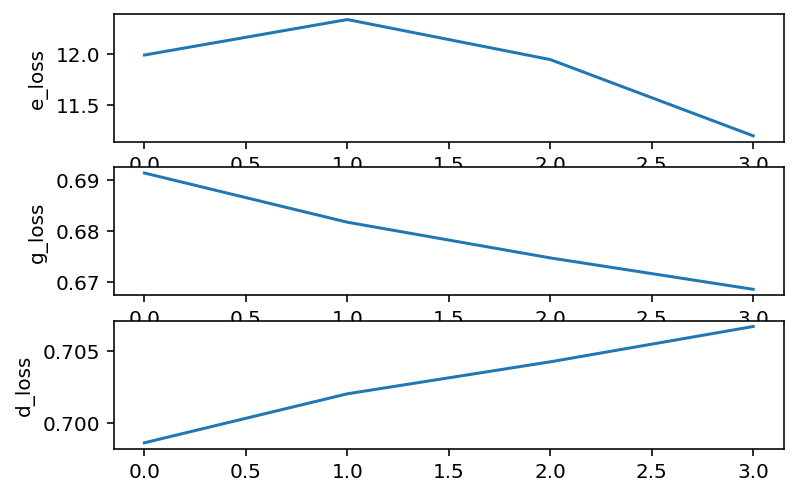

getting data
(100, 1536, 88)
got data
step 1


In [ ]:
loss_dict= {
    'e_loss':[],
    'g_loss':[],
    'd_loss':[]
    
}
for e in range(epochs):
    num_batches = num_total_data // batch_size
    dis_list = list(range(num_total_data))
    gen_list = list(range(num_total_data))
    random.shuffle(dis_list)
    random.shuffle(gen_list)
    for i in range(num_batches):
        print("getting data")
        start_data_gen = next_batch(gen_list[i*batch_size:i*batch_size + batch_size], 1536)
        sequences_dis = next_batch(dis_list[i*batch_size:i*batch_size + batch_size], 3072)
        print(start_data_gen.shape)
        print("got data")
        encoder_loss = encoder_decoder.train_on_batch([sequences_dis,start_data_gen], [sequences_dis, start_data_gen])
        print("step 1"),
        total_fake_data = generator.predict(start_data_gen)
        d_loss_fake = discriminator.train_on_batch(total_fake_data, tf.zeros(batch_size))
        d_loss_real = real_discriminator.train_on_batch(sequences_dis, tf.ones(batch_size)*.9)
        print(real_discriminator.predict(sequences_dis))
        print(d_loss_real)
        print("step 2")
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = combined.train_on_batch(start_data_gen, tf.ones(batch_size))
        g_test = decoder_model.predict(generator.predict(start_data_gen))
        print(g_test)
        print("batch {} completed! encoder loss: {} discriminator loss: {} generator_loss: {}".format(i, encoder_loss[0],d_loss,g_loss))
        loss_dict['e_loss'].append(encoder_loss[0])
        loss_dict['g_loss'].append(g_loss)
        loss_dict['d_loss'].append(d_loss)
        plt.clf()
        plt.subplot(3,1,1)
        plt.plot(loss_dict['e_loss']) # plot something
        plt.ylabel("e_loss")
        plt.subplot(3,1,2)
        plt.plot(loss_dict['g_loss'])
        plt.ylabel("g_loss")
        plt.subplot(3,1,3)
        plt.plot(loss_dict['d_loss'])
        plt.ylabel("d_loss")
        plt.pause(0.01)
        fig.canvas.draw()
        if i % 10 == 0:
            print("10 batches completed")
            single_start_data = next_batch([random.randint(0,num_total_data)], 1536)
            sample_new_data = generator.predict(single_start_data)
            #with open("./test_results/test1.pickle", "wb+") as file:
            #    pickle.dump(sample_new_data, file)
        encoder_decoder.save("./models/encoder_decoder{}&{}.h5".format(e,i))
        discriminator.save("./models/discriminator{}&{}.h5".format(e,i))
        real_discriminator.save("./models/discriminator{}&{}.h5".format(e,i))
        generator.save("./models/generator{}&{}.h5".format(e,i))
        combined.save("./models/combined{}&{}.h5".format(e,i))
                              
                        